# Pairs Trading Strategy

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

In [3]:
# --- Parameters ---
stocks = ['KO', 'PEP', 'XOM', 'CVX', 'MSFT', 'AAPL', 'JPM', 'BAC']
start_date = '2019-01-01'
end_date = '2024-01-01'
total_capital = 10000
transaction_cost = 0.001
rolling_window_years = 1
step_months = 6

# --- Fetch Data ---
def download_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end, auto_adjust=True)['Close']
    return data.dropna()

prices = download_data(stocks, start_date, end_date)

[*********************100%***********************]  8 of 8 completed


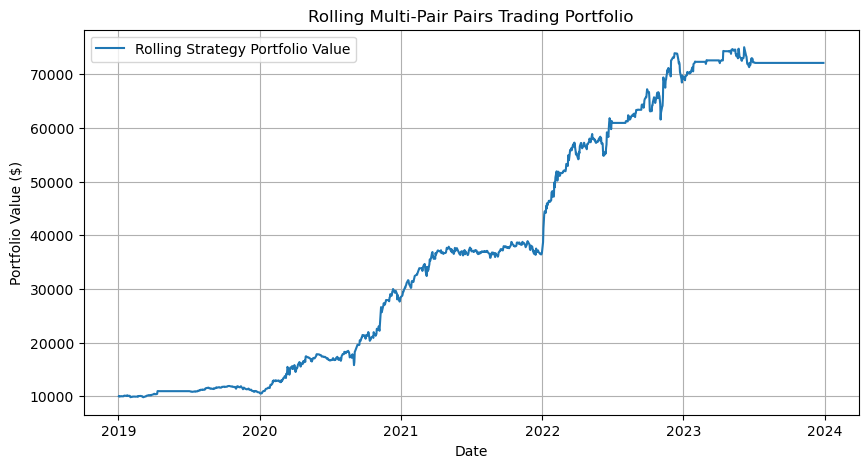

In [14]:
# --- Rolling Windows ---
all_dates = prices.index
returns_agg = pd.Series(0.0, index=all_dates)
rotation_log = []

start_idx = 0
while True:
    start_date = all_dates[start_idx]
    end_window = start_date + pd.DateOffset(years=rolling_window_years)
    if end_window > all_dates[-1]:
        break

    # Slice data for rolling window
    mask = (prices.index >= start_date) & (prices.index <= end_window)
    window_prices = prices.loc[mask]
    if len(window_prices) < 100:
        start_idx += 21 * step_months
        continue

    # --- Cointegration Test ---
    results = []
    for i in range(len(stocks)):
        for j in range(i+1, len(stocks)):
            s1 = window_prices[stocks[i]]
            s2 = window_prices[stocks[j]]
            score, pvalue, _ = coint(s1, s2)
            results.append((stocks[i], stocks[j], pvalue))

    sorted_pairs = sorted(results, key=lambda x: x[2])
    top_pairs = sorted_pairs[:3]
    pair_returns = pd.DataFrame(index=window_prices.index)

    # Log selected pairs and start date
    rotation_log.append((start_date.date(), [f"{a}-{b}" for a, b, _ in top_pairs]))

    for pair in top_pairs:
        s1 = window_prices[pair[0]]
        s2 = window_prices[pair[1]]

        spread = s1 - s2
        spread_mean = spread.mean()
        spread_std = spread.std()
        zscore = (spread - spread_mean) / spread_std

        position = []
        for z in zscore:
            if z > 1:
                position.append(-1)
            elif z < -1:
                position.append(1)
            else:
                position.append(0)
        position = pd.Series(position, index=zscore.index).shift(1).fillna(0)

        ret_s1 = s1.pct_change()
        ret_s2 = s2.pct_change()
        ret_spread = position * (ret_s1 - ret_s2)
        ret_spread = ret_spread.fillna(0)

        position_change = position.diff().abs().fillna(0)
        cost = position_change * 2 * transaction_cost
        ret_net = ret_spread - cost

        label = f"{pair[0]}-{pair[1]}"
        pair_returns[label] = ret_net

    avg_return = pair_returns.mean(axis=1)
    returns_agg.loc[avg_return.index] += avg_return

    start_idx += 21 * step_months

# --- Portfolio Value ---
portfolio = (1 + returns_agg).cumprod() * total_capital

# --- Plot Performance ---
plt.figure(figsize=(10, 5))
plt.plot(portfolio, label='Rolling Strategy Portfolio Value')
plt.title("Rolling Multi-Pair Pairs Trading Portfolio")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid()
plt.show()

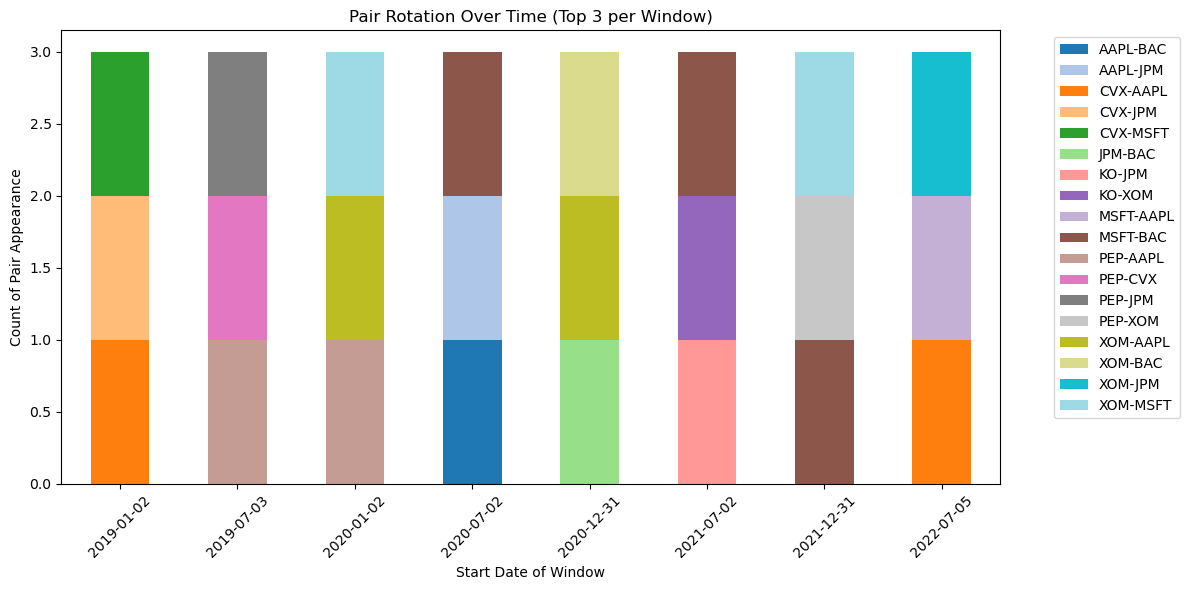

In [16]:
# --- Plot Pair Rotation ---
rotation_df = pd.DataFrame(rotation_log, columns=['Start Date', 'Pairs'])
rotation_df = rotation_df.explode('Pairs')
rotation_df['Count'] = 1
rotation_pivot = rotation_df.pivot_table(index='Start Date', columns='Pairs', values='Count', fill_value=0)

rotation_pivot.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title("Pair Rotation Over Time (Top 3 per Window)")
plt.xlabel("Start Date of Window")
plt.ylabel("Count of Pair Appearance")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Total Return: 621.19%
Annualized Sharpe Ratio: 1.96


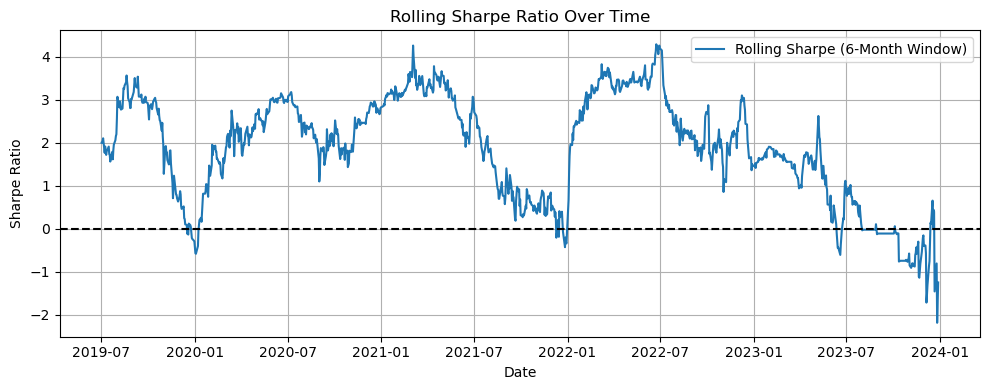

In [12]:
# --- Performance Metrics ---
total_return = portfolio.iloc[-1] / total_capital - 1
sharpe_ratio = returns_agg.mean() / returns_agg.std() * np.sqrt(252)
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")

# --- Rolling Sharpe Ratio ---
rolling_sharpe = returns_agg.rolling(window=126).mean() / returns_agg.rolling(window=126).std() * np.sqrt(252)

plt.figure(figsize=(10, 4))
plt.plot(rolling_sharpe, label='Rolling Sharpe (6-Month Window)')
plt.title("Rolling Sharpe Ratio Over Time")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.axhline(0, color='black', linestyle='--')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()